In [9]:
import csv
from rdflib import Graph, Literal, RDF, URIRef, Namespace
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

## Create RDF from CSV

In [10]:

# Create an RDF graph
g = Graph()

# Define the namespaces
FOAF = Namespace("http://xmlns.com/foaf/0.1/recipe")
RDFS = Namespace("http://www.w3.org/2000/01/rdf-schema#")
SCHEMA = Namespace("http://schema.org/recipes/")

# Open the CSV file and convert to readable format to allow
# processing row by row
with open('../dataset/final.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile)

    # Going through each row
    for row in reader:
        # Create a unique URI for the recipe
        recipe_uri = URIRef(f"http://example.com/recipe/{row['id']}")
        
        # Add RDF triples to the graph
        g.add((recipe_uri, RDF.type, SCHEMA.Recipe))
        g.add((recipe_uri, RDFS.label, Literal(row['title'])))
        g.add((recipe_uri, SCHEMA.id, Literal(row['id'])))
        g.add((recipe_uri, SCHEMA.ingredients, Literal(row['ingredients'])))
        g.add((recipe_uri, SCHEMA.NER, Literal(row['NER'])))
        g.add((recipe_uri, SCHEMA.NER_mapped, Literal(row['NER_mapped'])))
        g.add((recipe_uri, SCHEMA.NER_product_nl, Literal(row['NER_product_nl'])))
        g.add((recipe_uri, SCHEMA.NER_recipe_total_price, Literal(row['NER_recipe_total_price'])))

# Create RDF file 
g.serialize('../dataset/final.rdf', format='xml')


<Graph identifier=Nf1541c8810774a1ba123650b2bf1d7c8 (<class 'rdflib.graph.Graph'>)>

## Querying with SPARQL 

In [11]:
from rdflib import Graph

# Load your RDF graph from the file
g = Graph()
g.parse('../dataset/final.rdf', format='xml')
    
# Define the first SPARQL query selecting all recipes 
# with keyword of choice and its maximum price the students wants to pay in the title with prices sorted from low to high
keyword = "cookies"
max_price = 20.00
query = '''
    SELECT ?label ?NER_recipe_total_price ?NER ?NER_product_nl ?id
    WHERE {
      ?recipe rdfs:label ?label ;
              ns1:NER_recipe_total_price ?NER_recipe_total_price ;
              ns1:NER ?NER ;
              ns1:NER_product_nl ?NER_product_nl ;
              ns1:id ?id .
      FILTER (regex(?label, "''' + keyword + '''", "i"))
      FILTER (xsd:float(?NER_recipe_total_price) <= ''' + str(max_price) + ''')
    } 
    LIMIT 3
'''

# Execute the query and retrieve the results
results = g.query(query)

# Convert the prices to floats 
sorted_results = sorted(results, key=lambda row: float(row['NER_recipe_total_price']))

# Print the recipe titles, id, ingredients, and the total price for the recipe
count=0
label_list = []
ingr_list = []
ah_product_list = []
price_list = []
id_list = []
for row in sorted_results:
    count+=1
    id = row['id']
    print("Recipe: ", count,"\nRecipe id:", id)
    label = row['label']
    ingredients = row['NER']
    ah_product = row['NER_product_nl']
    price = round(float(row['NER_recipe_total_price']), 2)
    print(f"Recipe Name: {label}")
    print(f"Ingredients: {ingredients}")
    print(f"Price: {price}")
    print(f"Product: {ah_product}")
    print("------------------------------------------------------------------------")

    label_list.append(label)
    ingr_list.append(ingredients)
    ah_product_list.append(ah_product)
    price_list.append(price)
    id_list.append(id)
    

Recipe:  1 
Recipe id: 1436
Recipe Name: Schoolhouse Peanut Butter Cookies
Ingredients: ["brown sugar", "white sugar", "peanut butter", "eggs", "flour", "soda", "salt", "sweet milk", "vanilla"]
Price: 7.35
Product: ['AH Rietsuiker', 'AH Rietsuiker', 'AH Kruidenboter', 'AH Rondeel eieren M L', 'AH Tarwe bloem', 'Driehoek Vloeibare soda', 'AH Doperwten 0% zout', 'AH Karnemelk', 'AH Muffin vanille']
------------------------------------------------------------------------
Recipe:  2 
Recipe id: 1136
Recipe Name: Soft Date Cookies
Ingredients: ["dates", "soda", "sugar", "butter", "eggs", "vanilla", "flour", "salt"]
Price: 8.7
Product: ['AH Medjoul dadels', 'Driehoek Vloeibare soda', 'AH Rietsuiker', 'AH Kruidenboter', 'AH Rondeel eieren M L', 'AH Muffin vanille', 'AH Tarwe bloem', 'AH Doperwten 0% zout']
------------------------------------------------------------------------
Recipe:  3 
Recipe id: 2846
Recipe Name: Chewy Chocolate Chip Cookies
Ingredients: ["flour", "baking soda", "margari

In [12]:
# Create a dataframe from the query results
dict = {'label': label_list, 'ingredients': ingr_list, 'ah_product':ah_product_list, 'price':price_list, 'id':id_list}    
df = pd.DataFrame(dict)
df.head()

,label,ingredients,ah_product,price,id
0,Schoolhouse Peanut Butter Cookies,"[""brown sugar"", ""white sugar"", ""peanut butter""...","['AH Rietsuiker', 'AH Rietsuiker', 'AH Kruiden...",7.35,1436
1,Soft Date Cookies,"[""dates"", ""soda"", ""sugar"", ""butter"", ""eggs"", ""...","['AH Medjoul dadels', 'Driehoek Vloeibare soda...",8.70,1136
2,Chewy Chocolate Chip Cookies,"[""flour"", ""baking soda"", ""margarine"", ""brown s...","['AH Tarwe bloem', 'Dr. Oetker Baksoda', 'Bece...",9.68,2846


In [13]:
from ast import literal_eval

# make an array from the strings of arrays
for i in range(0, len(df)):
    df['ingredients'].iloc[i] = literal_eval(df['ingredients'].iloc[i])
    df['ah_product'].iloc[i] = literal_eval(df['ah_product'].iloc[i])

# add all unique ingredients and products to a list
all_products = []
all_ingredients = []
for i in range(0, len(df)):
    for prod in df['ah_product'].iloc[i]:
        if prod not in all_products:
            all_products.append(prod)
    for ingr in df['ingredients'].iloc[i]:
        if ingr not in all_ingredients:
            all_ingredients.append(ingr)


/tmp/ipykernel_32510/520503452.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ingredients'].iloc[i] = literal_eval(df['ingredients'].iloc[i])
/tmp/ipykernel_32510/520503452.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ah_product'].iloc[i] = literal_eval(df['ah_product'].iloc[i])
/tmp/ipykernel_32510/520503452.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ingredients'].iloc[i] = literal_eval(df['ingredients

In [14]:


# create a network graph
G = nx.Graph()

# add a node for each label, ingredient, product, price and ID
G.add_nodes_from(df['label'].values)
G.add_nodes_from(all_ingredients)
G.add_nodes_from(all_products)
G.add_nodes_from(df['price'].values)
G.add_nodes_from(df['id'].values)

In [15]:
# create a colorblind-friendly colormap for all nodes
color_map = []
[color_map.append('blue') for _ in range(0, len(df['label'].values))]
[color_map.append('red') for _ in range(0, len(all_ingredients))]
[color_map.append('yellow') for _ in range(0, len(all_products))]
[color_map.append('orange') for _ in range(0, len(df['price'].values))]
[color_map.append('gray') for _ in range(0, len(df['id'].values))]

[None, None, None]

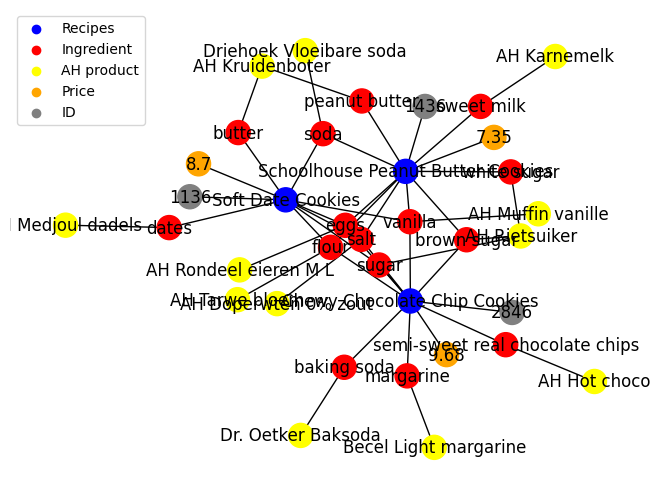

In [16]:
# add edges between nodes
for i in range(0, len(df)):
    for label in df['label'].values:
        for id in df['id'].values:
            # add an edge between corresponding labels and IDS
            if df['label'].iloc[i] == label and df['id'].iloc[i] == id:
                G.add_edge(label, id)
        for price in df['price'].values:
            # add an edge between corresponding labels and price
            if df['label'].iloc[i] == label and df['price'].iloc[i] == price:
                G.add_edge(label, price)
        for ingr in all_ingredients:
            # add an edge between corresponding labels and ingredients
            if df['label'].iloc[i] == label and ingr in df['ingredients'].iloc[i]:
                G.add_edge(label, ingr)

    # add an edge between corresponding ingredients and mapped AH products
    for j in range(0, len(df['ingredients'].iloc[i])):
        G.add_edge(df['ingredients'].iloc[i][j], df['ah_product'].iloc[i][j])

# draw the network graph
# nx.draw(G, node_color=color_map, with_labels = True)

# different layout for the network graph
nx.draw_kamada_kawai(G, node_color=color_map, with_labels = True)


# create empty scatter plot for the legend of the network graph
plt.scatter([],[], c='blue', label='Recipes')
plt.scatter([],[], c='red', label='Ingredient')
plt.scatter([],[], c='yellow', label='AH product')
plt.scatter([],[], c='orange', label='Price')
plt.scatter([],[], c='gray', label='ID')
plt.legend()
plt.show()
